In [95]:
import tkinter as tk
from tkinter import filedialog
import numpy as np  
import matplotlib.pyplot as plt
import cv2 
from scipy import ndimage
from skimage import exposure ,metrics

In [2]:
def select_images():
    root = tk.Tk()
    root.wm_attributes('-topmost', 1)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select Image Files", filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.gif;*.tif;*.bmp;")])
    if file_paths:
        image = cv2.imread(file_paths[0])
        image = cv2.resize(image, (640, 480))
    return image

In [3]:
def disp_img(img , title = 'img' ,text = {'text' : [None],'loc':[(165,500)]}):
    
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_RBUTTONUP:
            cv2.destroyAllWindows()
    
    I = img.copy()
    avg = np.mean(I)
    for  i , val  in  enumerate(text['text']):
        if avg> 128:
            cv2.putText(I, val, text['loc'][i], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        else:  
            cv2.putText(I, val, text['loc'][i], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1) 

    cv2.imshow(title ,I)
    cv2.setWindowProperty(title, cv2.WND_PROP_TOPMOST, 1)
    # Associate the callback function with the named window
    cv2.setMouseCallback(title, mouse_callback)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [113]:
########################################### Convert Color Spaces #####################################
def BGRtoHSV(BGR):
    hsv = cv2.cvtColor(BGR, cv2.COLOR_BGR2HSV)
    return cv2.split(hsv)

def HSVtoBGR(H,S,V):
    hsv = np.stack([H,S,V],axis=2)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

################################################ Denoise TV  #########################################
def denoise_tv(image, weight=1/90, eps=1.e-6, max_num_iter=200):
    """Perform total-variation denoising on n-dimensional images.
    
    Parameters
    ----------
    image : ndarray
        n-D input data to be denoised.
    weight : float, optional
        Denoising weight It is equal to 1/lambda . The greater `weight`, the more denoising .
        
    eps : float, optional
        Relative difference of the value of the cost function that determines
        the stop criterion. The algorithm stops when:
            (E_(n-1) - E_n) < eps * E_0
        where E_0 is the initial value of the cost function.    

    max_num_iter : int, optional
        Maximal number of iterations used for the optimization.

    Returns
    -------
    out : ndarray
        Denoised array  uint8 [0 - 255].
    """
    image = image.astype(np.float64) # convert image to float
    ndim = image.ndim
    p = np.zeros((image.ndim, ) + image.shape, dtype=image.dtype)
    g = np.zeros_like(p)
    d = np.zeros_like(image)
    i = 0
    while i < max_num_iter:
        if i > 0:
            # d will be the (negative) divergence of p
            d = -p.sum(0)
            slices_d = [slice(None), ] * ndim
            slices_p = [slice(None), ] * (ndim + 1)
            for ax in range(ndim):
                slices_d[ax] = slice(1, None)
                slices_p[ax+1] = slice(0, -1)
                slices_p[0] = ax
                d[tuple(slices_d)] += p[tuple(slices_p)]
                slices_d[ax] = slice(None)
                slices_p[ax+1] = slice(None)
            out = image + d
        else:
            out = image
        E = (d ** 2).sum()

        # g stores the gradients of out along each axis
        # e.g. g[0] is the first order finite difference along axis 0
        slices_g = [slice(None), ] * (ndim + 1)
        for ax in range(ndim):
            slices_g[ax+1] = slice(0, -1)
            slices_g[0] = ax
            g[tuple(slices_g)] = np.diff(out, axis=ax)
            slices_g[ax+1] = slice(None)

        norm = np.sqrt((g ** 2).sum(axis=0))[np.newaxis, ...] # calculate magnitude
        E += weight * norm.sum() # Update cost function
        tau = 1. / (2.*ndim) # calc step 
        norm *= tau / weight
        norm += 1.
        p -= tau * g
        p /= norm
        E /= float(image.size)
        if i == 0:
            E_init = E
            E_previous = E
        else:
            if np.abs(E_previous - E) < eps * E_init:
                break
            else:
                E_previous = E
        i += 1
    print(i,tau)    
    return out.astype(np.uint8)

######################################## Adaptive Gamma Correction ###################################
def adaptive_gamma_transform(img, n,m):
    """
    Applies adaptive gamma transform on a given image.

    Args:
        img: A grayscale image to be processed.
        m: Size of the local area (height).
        n: Size of the local area (width).

    Returns:
        A gamma corrected image.
    """
    rows, cols = img.shape
    gamma_corrected = np.zeros((rows, cols))

    # Add small value to ignore zero division error and convert to float
    img = (img+1.)/255. 

    for i in range(rows):
        for j in range(cols):
            rmin = max(0, i - m//2)
            rmax = min(rows, i + m//2 + 1)
            cmin = max(0, j - n//2)
            cmax = min(cols, j + n//2 + 1)
            local_area = img[rmin:rmax, cmin:cmax]

            N = np.mean(local_area) # calculate mean on local area n x m
            b = np.var(local_area)  # calculate var on local area n x m

            # Calculate the gamma value.
            gamma = N/img[i,j] + b

            # Gamma correct the pixel value.
            gamma_corrected[i,j] = np.power(img[i,j], gamma)

    return (gamma_corrected*255).astype(np.uint8) # transform back to uint8 [0 - 255]

#################################################### MSR #############################################
def get_ksize(sigma):
    # Opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # Perform convolution I(i,j)*G(i,j)
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)
    
    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*G(x, y))
    # G = surrounding function,( Gaussian )
    
    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250],apply_normalization=True):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales
    img = img + 1.0 # add small value to ignore log(0)
    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)
    
    # divide MSR by weights of each scale
    # here we use equal weights 
    msr = msr / len(sigma_scales)
    
    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    if apply_normalization: 
       return cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    else: 
       return msr


############################### Multi-scale Hyperbolic Tangent Enhancement ###########################
def tanh(img, sigma):
    # Single-scale Hyperbolic Tangent Enhancement
    # tanh(I(x,y) / (I(x, y)*G(x, y)))
    # G = surrounding function,( Gaussian )
    return np.tanh(img/get_gaussian_blur(img, ksize=0, sigma=sigma))

def mtanh(img, sigma_scales=[15, 80, 250]):
    # Multi-scale Hyperbolic Tangent Enhancement
    img = img + 1.0 # add small value to ignore zero division
    i_t = np.zeros(img.shape)
    # for each sigma scale compute tanh
    for sigma in sigma_scales:
        i_t += tanh(img, sigma)
    
    # divide tanh by weights of each scale
    # here we use equal weights 1/3
    i_t = i_t / len(sigma_scales)
    
    return (i_t*255).astype(np.uint8) # transform back to uint8 [0 - 255]


################################### Double-Function Image Enhancement ################################
def DFIE(img , sigma=[10,40,300],n = 3,m= 3):
    i_l = msr(img,sigma).astype(np.float64) # calculate  weighted MSR
    i_t = mtanh(img,sigma).astype(np.float64) # calculate  weighted tanh
    
    # Using gausian to estimate mean , much faster than do in in loop
    i_l_mean = cv2.blur(i_l, (n, m))
    i_t_mean = cv2.blur(i_t, (n, m))
    a= i_t_mean/i_l_mean
    alpha = cv2.normalize(a, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    
    balanced = alpha*i_l + (1-alpha)*i_t
   
    # # Same as above but take much longer to calculate
    # rows, cols = img.shape
    # balanced = np.zeros((rows, cols))

    # for i in range(rows):
    #     for j in range(cols):
    #         rmin = max(0, i - m//2)
    #         rmax = min(rows, i + m//2 + 1)
    #         cmin = max(0, j - n//2)
    #         cmax = min(cols, j + n//2 + 1)
    #         # Calculate the indices for the local area.
    #         local_i_l = i_l[rmin:rmax, cmin:cmax]
    #         local_i_t = i_t[rmin:rmax, cmin:cmax]
    #         alpha = np.mean(local_i_t)/np.mean(local_i_l)
    #         balanced[i,j] = alpha*i_l[i,j]+(1-alpha)*i_t[i,j]

    return balanced.astype(np.uint8) # transform back to uint8 [0 - 255]


################################## Three-Dimensional Gamma Correction ################################
def three_dim_gamma_correction(image, weights=[0.05,0.05,0.2], n=3, m=3):
    # add some small value to ignore zerro division and convert to float [0.0 - 1.0]
    image = (image+1.)/255. 
    # Initialize output image
    output_image = np.zeros_like(image)
    rows, cols = image.shape
    
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    Gr =np.hypot(gx,gy) # calculate magnitude, same as sqrt(gx**2 +gy**2)
    # Iterate over each pixel in the input image
    for i in range(rows):
        for j in range(cols):
            rmin = max(0, i - m//2)
            rmax = min(rows, i + m//2 + 1)
            cmin = max(0, j - n//2)
            cmax = min(cols, j + n//2 + 1)
            # Extract local region of size n x m around the pixel
            local_region = image[rmin:rmax, cmin:cmax]
            # Compute local maximum, mean gradient, and variance
            local_max = np.max(local_region)
            local_mean_gradient = np.mean(Gr[i:i+n, j:j+m])
            local_variance = np.var(local_region)

            # Compute gamma correction factor based on local statistics and weights
            gamma = weights[0]*np.exp(image[i,j]/local_max) + weights[1]*np.exp(local_mean_gradient) + weights[2]*np.exp(local_variance)

            # Apply gamma correction to pixel value
            output_image[i,j] = np.power(image[i,j],gamma)*255

    return output_image.astype(np.uint8) # transform back to uint8 [0 - 255]

#################################### Adaptive Saturation  Correction #################################

def adaptive_saturation_adjustment(s_channel,n,m):
    # add some small value to ignore zerro division and convert to float [0.0 - 1.0]
    s_channel= (s_channel+1.)/255
    rows, cols = s_channel.shape
    saturation_corrected = np.zeros((rows, cols))

    # Get x-gradient in "sx"
    sx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=3)
    # Get y-gradient in "sy"
    sy = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=3)
    # Get square root of sum of squares

    Sg=np.hypot(sx,sy)
    
    # # Compute the global mean value of the S channel
    S_mean = np.mean(s_channel)

    for i in range(rows):
        for j in range(cols):
            rmin = max(0, i - m//2)
            rmax = min(rows, i + m//2 + 1)
            cmin = max(0, j - n//2)
            cmax = min(cols, j + n//2 + 1)
            # Extract local region of size n x m around the pixel
            local_region = s_channel[rmin:rmax, cmin:cmax]
            # Calculate the average  of the local area.
            Sm = np.mean(local_region)

            # Apply regulation
            if s_channel[i,j] <= S_mean+Sg[i,j]:
                saturation_corrected[i,j] = 1+0.8*np.log10(Sm/(s_channel[i,j]+0.5*Sg[i,j]))   
            else:
                saturation_corrected[i,j] = np.exp((Sm-s_channel[i,j])/2)
    
    return  cv2.normalize(saturation_corrected, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

############################### Multi Scale Retinex with Color Restoration ###########################
def color_balance(img, low_per, high_per):
    '''Contrast stretch img by histogram equilization with black and white cap'''
    
    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)
    
    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li 
                        else (255 if i > hi else round((i - li) / (hi - li) * 255)) 
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)
    
    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None

def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=1):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels
    
    img = img + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales, apply_normalization=False)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr = G * (msr_img*crf - b)
    # normalize MSRCR
    msrcr = cv2.normalize(msrcr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr = color_balance(msrcr, low_per, high_per)
    
    return msrcr






################################################ Metrics #############################################
def PSNR(I_r, I_f):
    mse = np.mean((I_r - I_f) ** 2)
    max_pixel = 255
    psnr = 10 * np.log10(max_pixel ** 2 / mse)
    # psnr = 20 * np.log10(max_pixel/np.sqrt(mse))
    return round(psnr, 4)


def SD(I_f):
    # Compute the histogram
    hist, bins = np.histogram(I_f.flatten(), bins=256)
    # Compute the mean of the histogram
    mean = np.sum(hist * bins[:-1]) / np.sum(hist)

    # Compute the variance of the histogram
    variance = np.sum((bins[:-1] - mean) ** 2 * hist) / np.sum(hist)

    # Compute the standard deviation of the histogram
    return round(np.sqrt(variance), 4)


def SSIM(I_r, I_f, L=255):
    ssim = metrics.structural_similarity(I_r, I_f,gaussian_weights=True,data_range=L)
    return round(ssim, 4)

def IE(I_f):
    # Add epsilon to avoid division by zero errors
    epsilon = 2**(-32) 
    # Compute the histogram of the image
    hist, _ = np.histogram(I_f.flatten(), bins=256)

    # Calculate the total number of pixels in the image
    num_pixels = np.sum(hist) # same as N*M

    # Calculate the PMF by dividing each bin in the histogram by the total number of pixels
    hist_p = hist / num_pixels

    hist_p = np.clip(hist_p, epsilon, 1)
    E = -np.sum(hist_p * np.log2(hist_p))
    return round(E, 4)


def metric(I_ref ,I_enc):
    I_ref_gray = cv2.cvtColor(I_ref, cv2.COLOR_BGR2GRAY)
    I_enc_gray = cv2.cvtColor(I_enc, cv2.COLOR_BGR2GRAY)
    info_ref = {'PSNR': PSNR(I_ref_gray, I_enc_gray),'SSIM': SSIM(I_ref_gray, I_enc_gray, L=255),'SD': SD(I_enc_gray) ,'IE':IE(I_enc_gray)}
    return info_ref

In [18]:
def Model(Img ,model = 'Double-function enhancement' ,disp_selector = [True ,False ,False,False ,False,False ,False, False ,False]
           ,sigma = [10,40,400],weights=[0.05,0.05,0.2]):
    
      if model == 'Double-function enhancement':
         # disp_selector = [Original , Original & I_o,  HSV ,I_d,I_p,I_out,I_img,I_u,S_tag ]
         h,s,v = BGRtoHSV(Img) 

         ######################### V - Channel #########################
         I_u_V= denoise_tv(v, weight=1/40, eps=1e-6, max_num_iter=100)
         I_d = adaptive_gamma_transform(I_u_V,n=3,m=3)
         I_p = DFIE(I_d , sigma,n = 9,m = 9)
         I_out = three_dim_gamma_correction(I_d,weights,n=9,m=9)
         I_img = ((I_out/255.*I_p/255.)*255).astype(np.uint8)

         ######################### S - Channel #########################
         I_u= denoise_tv(s, weight=1/40, eps=1e-6, max_num_iter=100)
         S_tag = exposure.equalize_adapthist(I_u/255.)
         S_tag = cv2.normalize(S_tag, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
         
         ############################# I_o #############################
         I_o = HSVtoBGR(h,S_tag,I_img)
         I_o = HSVtoBGR(h,I_u,I_img)
         I_o_cb = color_balance(I_o,1,1)
         if disp_selector[0]:
            disp_img(Img, title = 'Original' ,text = {'text' : ['Original'],'loc':[(280,460)]})
         if disp_selector[1]:
            disp_img(np.block([[Img],[I_o],[I_o_cb]]) , title = 'Enhancement' ,text = {'text' : ['Original','Enhancement','Enhancement + Color Balance'],'loc':[(280,460),(640+280,460),(640*2+230,460)]})     
         if disp_selector[2]:
            disp_img(np.block([h,s,v]) , title = 'HSV' ,text = {'text' : ['h-channel','s-channel','v-channel'],'loc':[(280,460),(640+280,460),(640*2+280,460)]})  
         if disp_selector[3]:
            disp_img(I_d, title = 'I_d' ,text = {'text' : ['I_d'],'loc':[(280,460)]})
         if disp_selector[4]:
            disp_img(I_p, title = 'I_p' ,text = {'text' : ['I_p'],'loc':[(280,460)]})
         if disp_selector[5]:
            disp_img(I_out, title = 'I_out' ,text = {'text' : ['I_out'],'loc':[(280,460)]})
         if disp_selector[6]:
            disp_img(I_img, title = 'I_img' ,text = {'text' : ['I_img'],'loc':[(280,460)]})
         if disp_selector[7]:
            disp_img(I_u, title = 'I_u' ,text = {'text' : ['I_u'],'loc':[(280,460)]})
         if disp_selector[8]:
            disp_img(S_tag, title = 'S_tag' ,text = {'text' : ['S_tag'],'loc':[(280,460)]})
         return  I_o ,I_o_cb
      if model == 'MSRCR':
         I_o = msrcr(Img,sigma_scales=sigma) 
         if disp_selector[0]:
            disp_img(Img, title = 'Original' ,text = {'text' : ['Original'],'loc':[(280,460)]})
         if disp_selector[1]:
            disp_img(np.block([[Img],[I_o]]) , title = 'Enhancement' ,text = {'text' : ['Original','Enhancement'],'loc':[(280,460),(640+280,460)]})  
         return  I_o        
            
             

In [114]:
Img =select_images()
h,s,v = BGRtoHSV(Img)

UnboundLocalError: local variable 'image' referenced before assignment

In [115]:
disp_selector = [0 ,True ,0,0 ,0 ,0 ,0 ,0 ,0]
Io =Model(Img ,model = 'MSRCR' ,disp_selector =disp_selector
           ,sigma = [30,100,300],weights=[0.01,0.01,0.25])
metric(Img,Io)

{'PSNR': 27.4991, 'SSIM': 0.3853, 'SD': 51.7735, 'IE': 7.5327}

In [116]:
print(metric(Img,Iocb))
metric(Img,Io)

{'PSNR': 27.4259, 'SSIM': 0.5556, 'SD': 48.8165, 'IE': 7.255}


{'PSNR': 27.4991, 'SSIM': 0.3853, 'SD': 51.7735, 'IE': 7.5327}

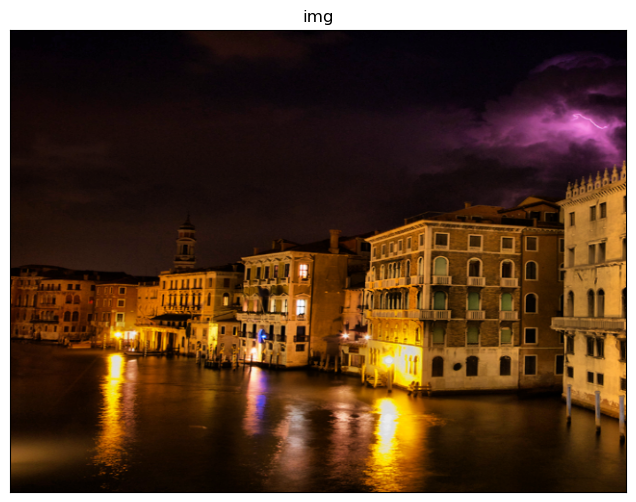

{'PSNR': 32.0666, 'SSIM': 0.935, 'SD': 39.4146, 'IE': 6.4397}

In [107]:
import skimage
def img_plot(img,title = 'img'):
    plt.figure(figsize=(8,6))
    plt.imshow((img), cmap=plt.cm.gray)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.title(title)  
    plt.show()
I = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
eq = skimage.exposure.equalize_adapthist(I)
eq = cv2.normalize(eq, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
img_plot(eq)
metric(Img,eq)

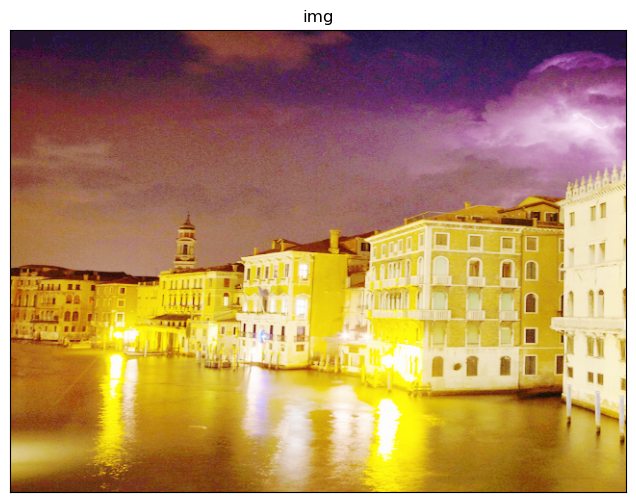

In [14]:

dst = skimage.exposure.equalize_hist(I)
img_plot(dst)


In [106]:
disp_img(np.block([[Io],[color_balance(Io,1,1)]]))

In [87]:
eq

array([[[0.01555583, 0.00518528, 0.02592638],
        [0.01797725, 0.00599242, 0.03595451],
        [0.01797725, 0.00599242, 0.03595451],
        ...,
        [0.01736578, 0.00578859, 0.03473156],
        [0.00988137, 0.        , 0.02470344],
        [0.01736578, 0.00578859, 0.03473156]],

       [[0.01196955, 0.00398985, 0.0159594 ],
        [0.0079797 , 0.        , 0.0159594 ],
        [0.01037055, 0.        , 0.02592638],
        ...,
        [0.01736578, 0.00578859, 0.03473156],
        [0.00985692, 0.        , 0.02464229],
        [0.01736578, 0.00578859, 0.03473156]],

       [[0.01797725, 0.00599242, 0.03595451],
        [0.01797725, 0.00599242, 0.03595451],
        [0.01797725, 0.00599242, 0.03595451],
        ...,
        [0.01736578, 0.00578859, 0.03473156],
        [0.01157719, 0.00578859, 0.03473156],
        [0.01157719, 0.00578859, 0.03473156]],

       ...,

       [[0.03491501, 0.0174575 , 0.006983  ],
        [0.03491501, 0.0174575 , 0.0034915 ],
        [0.02488688, 0

In [56]:
def LOE(segmented_image, ground_truth_image):
    """
    Calculate the Lightness Order Error (LOE) for a segmented image
    and its corresponding ground-truth image.

    Parameters:
    segmented_image (ndarray): A numpy array representing the segmented image.
    ground_truth_image (ndarray): A numpy array representing the ground-truth image.

    Returns:
    float: The LOE value.
    """
    # Convert the images to grayscale
    segmented_image = np.mean(segmented_image, axis=2)
    ground_truth_image = np.mean(ground_truth_image, axis=2)

    # Normalize the images
    segmented_image = segmented_image / np.max(segmented_image)
    ground_truth_image = ground_truth_image / np.max(ground_truth_image)

    # Calculate the LOE
    num_pixels = segmented_image.shape[0] * segmented_image.shape[1]
    loe = np.sum(np.abs(np.argsort(np.argsort(segmented_image.flatten())) -
                np.argsort(np.argsort(ground_truth_image.flatten())))) / (2 * num_pixels)

    return loe
LOE(msrcr(Img),Img)

19192.343723958333

In [81]:
def CE(I_f):
    # Add epsilon to avoid division by zero errors
    epsilon = 2**(-32) 
    # Compute the histogram of the image
    hist, _ = np.histogram(I_f.flatten(), bins=256)

    # Calculate the total number of pixels in the image
    num_pixels = np.sum(hist) # same as N*M

    # Calculate the PMF by dividing each bin in the histogram by the total number of pixels
    hist_p = hist / num_pixels

    hist_p = np.clip(hist_p, epsilon, 1)
    CE = -np.sum(hist_p * np.log2(hist_p))
    return round(CE, 4)
print(CE(msrcr(Img)))
print(CE(Io))

7.0893
7.2749


In [78]:
from scipy.stats import entropy
def calculate_entropy(image):
    # Flatten the image into a 1D array
    flattened_image = image.flatten()
    
    # Use numpy histogram to get the frequency of each pixel value
    pixel_freq, _ = np.histogram(flattened_image, bins=256)
    
    # Normalize the frequencies
    pixel_freq = pixel_freq.astype(float) / pixel_freq.sum()
    
    # Calculate the entropy
    entropy_value = entropy(pixel_freq, base=2)
    
    return entropy_value
print(calculate_entropy(Io))

7.274881282600142
